<a href="https://colab.research.google.com/github/minjung21/Final-Team9/blob/main/%EB%A9%8B%EC%82%AC_%ED%8C%8C%EC%9D%B4%EB%84%90_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_20250930.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 타겟 변수 생성 (0,1 -> 0 / 2, 3 -> 1)

In [ ]:
# ==============================================================================
# 0. 라이브러리 및 환경설정
# ==============================================================================
import pandas as pd
import numpy as np
import re
from pathlib import Path
from scipy import sparse

# 머신러닝 관련 라이브러리
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

# --- 환경설정 (CONFIG) ---
CSV_PATH = "/content/TMDB_processed_final.csv"
TARGET   = "y_result"

# 피처 엔지니어링 대상 컬럼 정의
TEXT_COLS = ["keywords", "overview", "tagline"]      # TF-IDF 벡터화 대상
TE_COLS   = ["director", "cast", "production_companies", "genres", "original_language"] # K-Fold 타겟 인코딩 대상
NUM_COLS  = ["runtime", "budget"]                     # 기본 수치형 컬럼

# 하이퍼파라미터
TFIDF_MAX_FEATURES = 20000  # TF-IDF 최대 단어 수
TE_N_SPLITS        = 5      # K-Fold 폴드 개수
TE_SMOOTHING       = 50.0   # 타겟 인코딩 스무딩 값

RANDOM_STATE = 42
TEST_SIZE    = 0.2

# ==============================================================================
# 1. 데이터 로드 및 기본 전처리
# ==============================================================================
print("--- 1. 데이터 로드 및 기본 전처리 시작 ---")
df = pd.read_csv(Path(CSV_PATH))

# --- 타겟 변수 생성 (0,1,2 -> 0 / 3 -> 1) ---
y = df[TARGET].map(lambda v: 0 if v in [0, 1] else 1).astype(int)
X = df.drop(columns=[TARGET])

# --- 날짜/수치 파생 변수 생성 ---
X['release_date'] = pd.to_datetime(X['release_date'], errors='coerce')
X['release_year'] = X['release_date'].dt.year
X['release_month'] = X['release_date'].dt.month
X['log_budget'] = np.log1p(X['budget'].clip(lower=0))

# --- 텍스트 정제 함수 ---
def clean_text(s):
    if pd.isna(s): return ""
    s = str(s).lower().strip()
    s = re.sub(r"\s*,\s*", " ", s) # 쉼표를 공백으로
    s = re.sub(r"\s+", " ", s)     # 여러 공백을 하나로
    return s

for c in TEXT_COLS:
    if c in X.columns:
        X[c] = X[c].apply(clean_text)

# ==============================================================================
# 2. 학습/검증 데이터 분할
# ==============================================================================
print("\n--- 2. 학습/검증 데이터 분할 ---")
# stratify=y : y의 클래스 비율을 유지하며 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
print(f"Train: {X_train.shape}, Valid: {X_valid.shape}")


# ==============================================================================
# 3. 피처 엔지니어링 (데이터 분할 후 적용)
# ==============================================================================
print("\n--- 3. 피처 엔지니어링 시작 ---")

# --- 3-1. K-Fold 타겟 인코딩 (데이터 누수 방지) ---
def kfold_target_encoding_binary(train_cat, y_train, valid_cat, n_splits, smoothing, seed):
    train_cat = train_cat.astype(str).fillna("None")
    valid_cat = valid_cat.astype(str).fillna("None")
    prior = y_train.mean()

    oof = np.zeros(len(train_cat), dtype=float)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for tr_idx, va_idx in kf.split(train_cat):
        tr_cat, tr_y = train_cat.iloc[tr_idx], y_train.iloc[tr_idx]
        g = pd.DataFrame({"cat": tr_cat, "y": tr_y}).groupby("cat")["y"].agg(["sum", "count"])
        p = (g["sum"] + smoothing * prior) / (g["count"] + smoothing)
        oof[va_idx] = train_cat.iloc[va_idx].map(p).fillna(prior).values

    g_all = pd.DataFrame({"cat": train_cat, "y": y_train}).groupby("cat")["y"].agg(["sum", "count"])
    p_all = (g_all["sum"] + smoothing * prior) / (g_all["count"] + smoothing)
    valid_enc = valid_cat.map(p_all).fillna(prior).values
    return oof, valid_enc

# 타겟 인코딩된 피처를 저장할 DataFrame 생성
X_train_te = pd.DataFrame(index=X_train.index)
X_valid_te = pd.DataFrame(index=X_valid.index)

for col in TE_COLS:
    if col in X_train.columns:
        print(f"  - K-Fold Target Encoding for '{col}'...")
        tr_enc, va_enc = kfold_target_encoding_binary(
            X_train[col], y_train, X_valid[col],
            n_splits=TE_N_SPLITS, smoothing=TE_SMOOTHING, seed=RANDOM_STATE
        )
        X_train_te[f'{col}_te'] = tr_enc
        X_valid_te[f'{col}_te'] = va_enc

# --- 3-2. TF-IDF 텍스트 벡터화 ---
print("  - TF-IDF Vectorizing for text columns...")
# 3개의 텍스트 컬럼을 하나로 합쳐서 TF-IDF 적용
X_train['text_combined'] = X_train[TEXT_COLS].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
X_valid['text_combined'] = X_valid[TEXT_COLS].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

vectorizer = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES, token_pattern=r"[^ ]+")
X_train_tfidf = vectorizer.fit_transform(X_train['text_combined'])
X_valid_tfidf = vectorizer.transform(X_valid['text_combined'])

# --- 3-3. 수치형 피처 및 상호작용 피처 생성 ---
print("  - Creating Numeric & Interaction features...")
num_feature_cols = ['runtime', 'log_budget', 'release_year', 'release_month']
X_train_num = X_train[num_feature_cols].fillna(0)
X_valid_num = X_valid[num_feature_cols].fillna(0)

# 상호작용 피처
if 'director_te' in X_train_te.columns:
    X_train_num['budget_x_director'] = X_train_num['log_budget'] * X_train_te['director_te']
    X_valid_num['budget_x_director'] = X_valid_num['log_budget'] * X_valid_te['director_te']
    X_train_num['runtime_x_director'] = X_train_num['runtime'] * X_train_te['director_te']
    X_valid_num['runtime_x_director'] = X_valid_num['runtime'] * X_valid_te['director_te']

# ==============================================================================
# 4. 최종 데이터셋 결합
# ==============================================================================
print("\n--- 4. 최종 데이터셋 결합 ---")
# 수치형, 타겟 인코딩, TF-IDF 피처를 모두 결합
X_train_final = sparse.hstack([
    sparse.csr_matrix(X_train_num.values),
    sparse.csr_matrix(X_train_te.values),
    X_train_tfidf
]).tocsr()

X_valid_final = sparse.hstack([
    sparse.csr_matrix(X_valid_num.values),
    sparse.csr_matrix(X_valid_te.values),
    X_valid_tfidf
]).tocsr()

print(f"Final Train Matrix Shape: {X_train_final.shape}")
print(f"Final Valid Matrix Shape: {X_valid_final.shape}")


# ==============================================================================
# 5. SMOTE 오버샘플링 (학습 데이터에만 적용)
# ==============================================================================
print("\n--- 5. SMOTE 적용 (학습 데이터 불균형 처리) ---")
smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_final, y_train)

print(f"Original y_train distribution:\n{y_train.value_counts()}")
print(f"Resampled y_train distribution:\n{y_train_resampled.value_counts()}")
print(f"Resampled Train Matrix Shape: {X_train_resampled.shape}")
print("\n>>> 데이터 준비 완료! <<<")
print("이제 X_train_resampled, y_train_resampled 로 모델을 학습하고,")
print("X_valid_final, y_valid 로 성능을 평가할 수 있습니다.")

--- 1. 데이터 로드 및 기본 전처리 시작 ---

--- 2. 학습/검증 데이터 분할 ---
Train: (6594, 28), Valid: (1649, 28)

--- 3. 피처 엔지니어링 시작 ---
  - K-Fold Target Encoding for 'director'...
  - K-Fold Target Encoding for 'cast'...
  - K-Fold Target Encoding for 'production_companies'...
  - K-Fold Target Encoding for 'genres'...
  - K-Fold Target Encoding for 'original_language'...
  - TF-IDF Vectorizing for text columns...
  - Creating Numeric & Interaction features...

--- 4. 최종 데이터셋 결합 ---
Final Train Matrix Shape: (6594, 20011)
Final Valid Matrix Shape: (1649, 20011)

--- 5. SMOTE 적용 (학습 데이터 불균형 처리) ---
Original y_train distribution:
y_result
0    4129
1    2465
Name: count, dtype: int64
Resampled y_train distribution:
y_result
1    4129
0    4129
Name: count, dtype: int64
Resampled Train Matrix Shape: (8258, 20011)

>>> 데이터 준비 완료! <<<
이제 X_train_resampled, y_train_resampled 로 모델을 학습하고,
X_valid_final, y_valid 로 성능을 평가할 수 있습니다.


In [ ]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.metrics import f1_score, classification_report

lgbm = LGBMClassifier(
    objective='binary',
    num_leaves=64,
    learning_rate=0.05,
    n_estimators=2000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# fit에서 callbacks 사용
lgbm.fit(
    X_train_resampled, y_train_resampled,
    eval_set=[(X_valid_final, y_valid)],
    eval_metric="f1",
    callbacks=[
        early_stopping(stopping_rounds=100),
        log_evaluation(100)
    ]
)

# 예측
y_pred_proba = lgbm.predict_proba(X_valid_final)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

print("LightGBM F1:", f1_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))


[LightGBM] [Info] Number of positive: 4129, number of negative: 4129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.406218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 123125
[LightGBM] [Info] Number of data points in the train set: 8258, number of used features: 3833
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.595448
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.593626
LightGBM F1: 0.525560538116592
              precision    recall  f1-score   support

           0       0.72      0.80      0.76      1033
           1       0.59      0.48      0.53       616

    accuracy                           0.68      1649
   macro avg       0.65      0.64      0.64      1649
weighted avg       0.67      0.68      0.67      1649



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer

# F1 스코어를 평가 지표로 사용
f1_scorer = make_scorer(f1_score)

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 하이퍼파라미터 후보
param_grid = {
    'num_leaves': [31, 64, 128],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'n_estimators': [500, 1000, 2000]
}

lgbm = LGBMClassifier(objective='binary', random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=skf,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_resampled, y_train_resampled)

print("Best F1:", grid_search.best_score_)
print("Best params:", grid_search.best_params_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import lightgbm as lgb

# --- 6-1. Logistic Regression (Baseline) ---
print("\n--- 6-1. Logistic Regression (Baseline) ---")
log_reg = LogisticRegression(max_iter=5000, solver='saga')
log_reg.fit(X_train_resampled, y_train_resampled)

y_pred_lr = log_reg.predict(X_valid_final)

print("Accuracy:", accuracy_score(y_valid, y_pred_lr))
print("Precision:", precision_score(y_valid, y_pred_lr))
print("Recall:", recall_score(y_valid, y_pred_lr))
print("F1 Score:", f1_score(y_valid, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_valid, y_pred_lr))


--- 6-1. Logistic Regression (Baseline) ---
Accuracy: 0.600970285021225
Precision: 0.46601941747572817
Recall: 0.4675324675324675
F1 Score: 0.46677471636953

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.68      0.68      1033
           1       0.47      0.47      0.47       616

    accuracy                           0.60      1649
   macro avg       0.57      0.57      0.57      1649
weighted avg       0.60      0.60      0.60      1649



In [ ]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.metrics import f1_score, classification_report

lgb_model = lgb.LGBMClassifier(
    objective='binary',
    learning_rate=0.05,
    n_estimators=1500,
    num_leaves=63,
    max_depth=7,             # 깊이 제한
    min_data_in_leaf=50,     # 리프 최소 데이터 수
    min_gain_to_split=0.01,  # 최소 gain 조건
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    random_state=RANDOM_STATE
)


# fit에서 callbacks 사용
lgbm.fit(
    X_train_resampled, y_train_resampled,
    eval_set=[(X_valid_final, y_valid)],
    eval_metric="f1",
    callbacks=[
        early_stopping(stopping_rounds=100),
        log_evaluation(100)
    ]
)

# 예측
y_pred_proba = lgbm.predict_proba(X_valid_final)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

print("LightGBM F1:", f1_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

[LightGBM] [Info] Number of positive: 4129, number of negative: 4129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.635256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 123125
[LightGBM] [Info] Number of data points in the train set: 8258, number of used features: 3833
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.595448
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.593626
LightGBM F1: 0.525560538116592
              precision    recall  f1-score   support

           0       0.72      0.80      0.76      1033
           1       0.59      0.48      0.53       616

    accuracy                           0.68      1649
   macro avg       0.65      0.64      0.64      1649
weighted avg       0.67      0.68      0.67      1649



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

lgb_model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    learning_rate=0.05,
    n_estimators=500,
    num_leaves=31,
    max_depth=6,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# sparse matrix에는 callbacks만 사용 가능
callbacks = [lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]

lgb_model.fit(
    X_train_resampled, y_train_resampled,
    eval_set=[(X_valid_final, y_valid)],
    eval_metric='binary_logloss',
    callbacks=callbacks
)

y_pred_lgb = lgb_model.predict(X_valid_final)

print("\nAccuracy:", accuracy_score(y_valid, y_pred_lgb))
print("Precision:", precision_score(y_valid, y_pred_lgb))
print("Recall:", recall_score(y_valid, y_pred_lgb))
print("F1 Score:", f1_score(y_valid, y_pred_lgb))
print("\nClassification Report:\n", classification_report(y_valid, y_pred_lgb))


Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.603255
[200]	valid_0's binary_logloss: 0.598376
[300]	valid_0's binary_logloss: 0.598362
Early stopping, best iteration is:
[258]	valid_0's binary_logloss: 0.596064

Accuracy: 0.6773802304426926
Precision: 0.5929203539823009
Recall: 0.43506493506493504
F1 Score: 0.50187265917603

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.82      0.76      1033
           1       0.59      0.44      0.50       616

    accuracy                           0.68      1649
   macro avg       0.65      0.63      0.63      1649
weighted avg       0.67      0.68      0.66      1649



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# ==============================================================================
# 0. 라이브러리
# ==============================================================================
import pandas as pd
import numpy as np
import re
from pathlib import Path
from scipy import sparse
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

# ==============================================================================
# 1. 데이터 로드 및 전처리
# ==============================================================================
CSV_PATH = "/content/TMDB_processed_final.csv"
TARGET = "y_result"

df = pd.read_csv(Path(CSV_PATH))

# 타겟 0,1,2 -> 0, 3 -> 1
y = df[TARGET].map(lambda v: 0 if v in [0,1] else 1).astype(int)
X = df.drop(columns=[TARGET])

# 날짜/수치형 파생
X['release_date'] = pd.to_datetime(X['release_date'], errors='coerce')
X['release_year'] = X['release_date'].dt.year
X['release_month'] = X['release_date'].dt.month
X['log_budget'] = np.log1p(X['budget'].clip(lower=0))

# 텍스트 정제
TEXT_COLS = ["keywords", "overview", "tagline"]
def clean_text(s):
    if pd.isna(s): return ""
    s = str(s).lower().strip()
    s = re.sub(r"\s*,\s*", " ", s)
    s = re.sub(r"\s+", " ", s)
    return s

for c in TEXT_COLS:
    X[c] = X[c].apply(clean_text)

# 텍스트 파생 피처
for col in TEXT_COLS:
    X[col + "_len"] = X[col].apply(lambda x: len(x))
    X[col + "_word_count"] = X[col].apply(lambda x: len(x.split()))

# 장르/감독 평균 점수 피처
genre_avg = df.groupby("genres")[TARGET].mean()
director_avg = df.groupby("director")[TARGET].mean()
X["genre_avg_score"] = X["genres"].map(genre_avg).fillna(genre_avg.mean())
X["director_avg_score"] = X["director"].map(director_avg).fillna(director_avg.mean())

# 날짜 파생
X['release_quarter'] = X['release_date'].dt.quarter.fillna(0)
X['is_recent'] = X['release_year'].apply(lambda x: 1 if x >= 2015 else 0)

# ==============================================================================
# 2. 학습/검증 분할
# ==============================================================================
RANDOM_STATE = 42
TEST_SIZE = 0.2
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# ==============================================================================
# 3. TF-IDF 벡터화
# ==============================================================================
TFIDF_MAX_FEATURES = 20000
X_train['text_combined'] = X_train[TEXT_COLS].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
X_valid['text_combined'] = X_valid[TEXT_COLS].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

vectorizer = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES, token_pattern=r"[^ ]+")
X_train_tfidf = vectorizer.fit_transform(X_train['text_combined'])
X_valid_tfidf = vectorizer.transform(X_valid['text_combined'])

# ==============================================================================
# 4. 수치형 + 파생 피처
# ==============================================================================
num_feature_cols = ['runtime','log_budget','release_year','release_month',
                    'keywords_len','keywords_word_count',
                    'overview_len','overview_word_count',
                    'tagline_len','tagline_word_count',
                    'genre_avg_score','director_avg_score',
                    'release_quarter','is_recent']

X_train_num = X_train[num_feature_cols].fillna(0)
X_valid_num = X_valid[num_feature_cols].fillna(0)

# ==============================================================================
# 5. 최종 학습용 matrix 결합
# ==============================================================================
X_train_final = sparse.hstack([X_train_tfidf, sparse.csr_matrix(X_train_num.values)]).tocsr()
X_valid_final = sparse.hstack([X_valid_tfidf, sparse.csr_matrix(X_valid_num.values)]).tocsr()

# ==============================================================================
# 6. SMOTE 적용
# ==============================================================================
smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_final, y_train)

# ==============================================================================
# 7. LightGBM 학습 (최적화 버전)
# ==============================================================================
lgb_model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    learning_rate=0.05,
    n_estimators=500,
    num_leaves=31,
    max_depth=6,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

callbacks = [lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]

lgb_model.fit(
    X_train_resampled, y_train_resampled,
    eval_set=[(X_valid_final, y_valid)],
    eval_metric='binary_logloss',
    callbacks=callbacks
)

# ==============================================================================
# 8. 평가
# ==============================================================================
y_pred = lgb_model.predict(X_valid_final)

print("\nAccuracy:", accuracy_score(y_valid, y_pred))
print("Precision:", precision_score(y_valid, y_pred))
print("Recall:", recall_score(y_valid, y_pred))
print("F1 Score:", f1_score(y_valid, y_pred))
print("\nClassification Report:\n", classification_report(y_valid, y_pred))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 4129, number of negative: 4129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.435088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 123812
[LightGBM] [Info] Number of data po

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


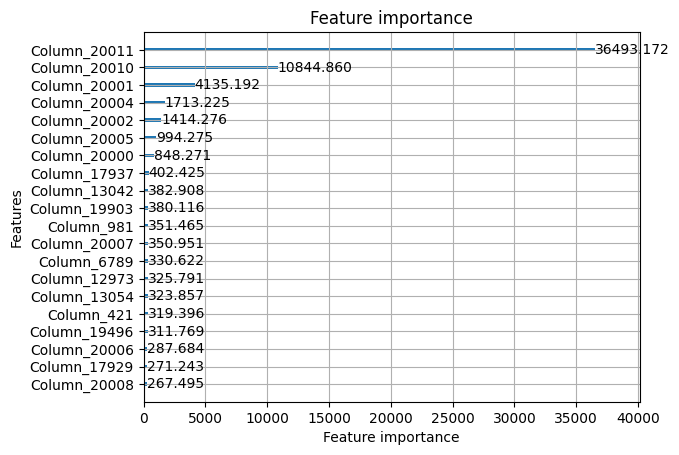

In [ ]:
import matplotlib.pyplot as plt
lgb.plot_importance(lgb_model, max_num_features=20, importance_type='gain')
plt.show()

                   feature  importance
20010      genre_avg_score         477
20011   director_avg_score         469
20001           log_budget         379
20004         keywords_len         161
20002         release_year         154
20000              runtime         138
20005  keywords_word_count          97
18152                   to          81
421                      a          80
17929                  the          77
20006         overview_len          68
20008          tagline_len          66
8695                    in          65
12973                   of          65
20007  overview_word_count          63
13042                   on          51
981                     an          50
8113                   his          48
20003        release_month          46
18204                  too          45


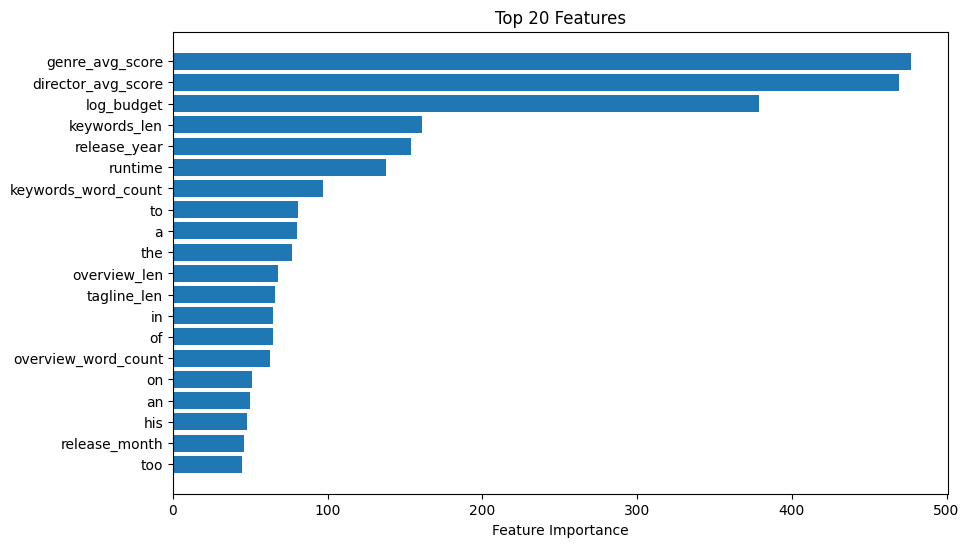

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# feature 이름 만들기
num_features = X_train_num.columns.tolist()
tfidf_features = vectorizer.get_feature_names_out().tolist()
all_features = tfidf_features + num_features

# 중요도 추출
importance = lgb_model.feature_importances_
feat_imp = pd.DataFrame({"feature": all_features, "importance": importance})
feat_imp = feat_imp.sort_values(by="importance", ascending=False)

# Top 20
top20 = feat_imp.head(20)
print(top20)

# 시각화
plt.figure(figsize=(10,6))
plt.barh(top20["feature"][::-1], top20["importance"][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Features")
plt.show()
